<a href="https://colab.research.google.com/github/JoseLuis96001/HyperparameterTunig_KerasTuner/blob/main/KerasTuner_TF_2_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Libraries

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.5 MB/s 
     |████████████████████████████████| 1.6 MB 43.3 MB/s 


In [ ]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
tf.__version__

'2.8.2'

In [ ]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

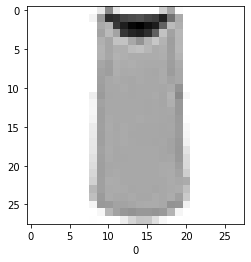

In [ ]:
plt.imshow(x_train[2], cmap='binary')
plt.xlabel(y_train[2])
plt.show()

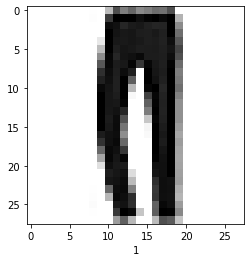

In [ ]:
plt.imshow(x_test[2], cmap='binary')
plt.xlabel(y_test[2])
plt.show()

In [ ]:
#from tensorflow.python.ops.gen_array_ops import inplace_update_eager_fallback
# def create_model(hp):
#   num_hidden_layers = 1 # this is a hyperparameter
#   num_units = 8 # another hyp...
#   dropout_rate = 0.1
#   learning_rate = 0.01

#   if hp:
#     num_hidden_layers = hp.Choice('num_hidden_layers', values = [1,2,3])
#     num_units = hp.Choice('num_units', values = [8,16,32])
#     dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
#     learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

#   model = tf.keras.models.Sequential() # used to groups a linear stack of layers into model.

#   model.add(tf.keras.layers.Flatten(input_shape = (28,28))) # flattens the multi-dimensional input tensors into a single dimension
#   model.add(tf.keras.layers.Lambda(lambda x: x/255.)) # normalization

#   for _ in range(0, num_hidden_layers):
#     model.add(tf.keras.layers.Dense(num_units, activation='relu')) # relu is an hy..
#     model.add(tf.keras.layers.Dropout(dropout_rate))

#   model.add(tf.keras.layers.Dense(10, activation='softmax'))

#   model.compile(
#       loss = "sparse_categorical_crossentropy",
#       optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
#       metrics = ['accuracy']
#   )

#   return model

Model Creation

In [ ]:
def create_model(hp):

  number_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers',values=[1,2,3])
    num_units = hp.Choice('num_units',values=[8,16,32])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1,max_value=0.5)
    #learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)
    learning_rate = np.asarray(hp.Float('learning_rate', min_value=1e-5, max_value=1e-2), dtype=np.float32)

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=(28,28))) # flattens the multi-dimensional input tensors into a single dimension
  model.add(tf.keras.layers.Lambda(lambda x:x/255,)) # normalization

  for _ in range(0,number_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units,activation='relu')) # relu is an hyperparameter too
    model.add(tf.keras.layers.Dropout(dropout_rate))
  
  model.add(tf.keras.layers.Dense(10, activation='softmax'))

  model.compile(
      loss = 'sparse_categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics = ['accuracy']
  )
  return model

In [ ]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


Keras Tuner

In [ ]:
class CustomTuner(kerastuner.tuners.BayesianOptimization): # posible between Random search, BayesianOptimization, HyperBand
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
    return super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
tuner = CustomTuner(
    create_model,
    objective = 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'fashin_mnist',
    overwrite =  True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': None}


In [ ]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5, verbose = True
)

Trial 20 Complete [00h 00m 11s]
val_accuracy: 0.8514999747276306

Best val_accuracy So Far: 0.8529000282287598
Total elapsed time: 00h 06m 34s


Results

In [ ]:
tuner.results_summary(1)

Results summary
Results in logs/fashin_mnist
Showing 1 best trials
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.1
learning_rate: 0.01
batch_size: 128
Score: 0.8529000282287598


In [ ]:
# one way

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]

In [ ]:
best_hp['batch_size'], best_hp['num_hidden_layers'], best_hp['num_units'], best_hp['dropout_rate'], best_hp['learning_rate']

(128, 1, 32, 0.1, 0.01)

In [ ]:
modelA = create_model(best_hp)
modelA.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 2nd way

In [ ]:
model = tuner.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


Model Fit

In [ ]:
mdfitt = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 20, batch_size = 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience = 3)]
)

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 0.4129 - accuracy: 0.8474 - val_loss: 0.4162 - val_accuracy: 0.8522
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4066 - accuracy: 0.8498 - val_loss: 0.4608 - val_accuracy: 0.8413
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4048 - accuracy: 0.8499 - val_loss: 0.4116 - val_accuracy: 0.8516
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3919 - accuracy: 0.8550 - val_loss: 0.4105 - val_accuracy: 0.8520
